<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="ffffff">
Resnet code

</font>
</h1>

pariya branch

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [16]:
# set common data augmentation parameters
data_augmentation = ImageDataGenerator(###
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# load training data
train_ds = data_augmentation.flow_from_directory(
    r'E:\projectDataset\archive\sl_train',
    class_mode='categorical',
    target_size=(224,224),####
    shuffle=True,
    batch_size=32
)

# load testing data
test_ds = ImageDataGenerator(preprocessing_function=resnet_preprocess_input).flow_from_directory(
    r'E:\projectDataset\archive\sl_test',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=False,
    batch_size=32
)

# load validation data
val_ds = ImageDataGenerator(preprocessing_function=resnet_preprocess_input).flow_from_directory(
    r'E:\projectDataset\archive\sl_valid',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)

Found 2907 images belonging to 12 classes.
Found 1166 images belonging to 12 classes.
Found 1420 images belonging to 12 classes.


In [17]:

# load ResNet50 pre-trained model
base_model = ResNet50(weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)

# set base model to trainable
base_model.trainable = True

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
fine_tune_at = 140

# freeze layers before fine-tune layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
# build classification model on top of ResNet50
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(12, activation='softmax'))

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [20]:

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:

# set early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=10)

# fine-tune the model
history = model.fit(
    train_ds,
    batch_size=32,
    epochs=5,
    #epochs=27,
    validation_data=val_ds,
  #  initial_epoch=22,
    callbacks=[early_stopping]
)

Epoch 1/5
91/91 [==============================] - 537s 6s/step - loss: 4.2368 - accuracy: 0.4126 - val_loss: 1.6572 - val_accuracy: 0.7056
Epoch 2/5
91/91 [==============================] - 511s 6s/step - loss: 0.7596 - accuracy: 0.8023 - val_loss: 2.0749 - val_accuracy: 0.7268
Epoch 3/5
91/91 [==============================] - 511s 6s/step - loss: 0.3929 - accuracy: 0.8847 - val_loss: 1.2460 - val_accuracy: 0.8289
Epoch 4/5
91/91 [==============================] - 510s 6s/step - loss: 0.4732 - accuracy: 0.8853 - val_loss: 0.8802 - val_accuracy: 0.8592
Epoch 5/5
91/91 [==============================] - 510s 6s/step - loss: 0.2934 - accuracy: 0.9275 - val_loss: 1.1463 - val_accuracy: 0.8303


In [22]:
test_loss, test_accuracy = model.evaluate(test_ds, steps=len(test_ds)/2)
print('Accuracy on test dataset:', test_accuracy)

18/18 [==============================] - 47s 3s/step - loss: 4.1365 - accuracy: 0.6546
Accuracy on test dataset: 0.6546052694320679


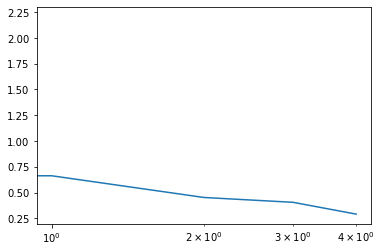

In [24]:
plt.semilogx( history.history["loss"])

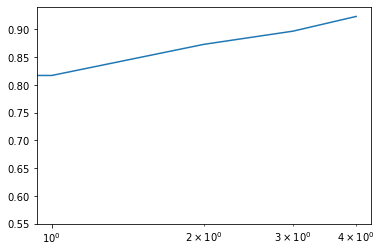

In [25]:
plt.semilogx( history.history["accuracy"])

In [ ]:
model.save('../models/8fruit_disease_classifier_resnet_FT.h5')